# Implementation of Vanilla GANs model with Gaussian dataset
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.autograd as autograd

import numpy as np
import datetime
import os, sys
import random

import sklearn.datasets

random.seed(42)
np.random.seed(42)

from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")
DATASET = '25gaussians'
NO_OF_BATCHES = 1000
BATCH_SIZE = 64
max_epoch = 100 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 2

In [4]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [5]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=2):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [6]:
def generate_image(dist):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    for idx in range(NO_OF_BATCHES):
        plt.scatter(dist[idx][:,0], dist[idx][:,1], c='blue', marker='+')

    z = torch.randn(BATCH_SIZE*NO_OF_BATCHES, n_noise).to(DEVICE)
    z_outputs = G(z)
    
    z_outputs = z_outputs.cpu().detach().numpy()
    
    plt.scatter(z_outputs[:,0], z_outputs[:,1], c='red', marker='+')
    plt.show()

In [7]:
def inf_train_gen():
    if DATASET == '25gaussians':

        dataset = []
        for i in range(int(100000 / 25)):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = np.random.randn(2) * 0.05
                    point[0] += 2 * x
                    point[1] += 2 * y
                    dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        np.random.shuffle(dataset)
        dataset /= 2.828  # stdev
        while True:
            for i in range(int(len(dataset) / BATCH_SIZE)):
                yield dataset[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE,
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5  # stdev plus a little
            yield data

    elif DATASET == '8gaussians':

        scale = 2.
        centers = [
            (1, 0),
            (-1, 0),
            (0, 1),
            (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        centers = [(scale * x, scale * y) for x, y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = np.random.randn(2) * .02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = np.array(dataset, dtype='float32')
            dataset /= 1.414  # stdev
            yield dataset


In [8]:


D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
D_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to fake

data = inf_train_gen()

train = []

for _ in range(NO_OF_BATCHES):
    data_ = next(data)
    train.append(data_)

train = np.array(train)

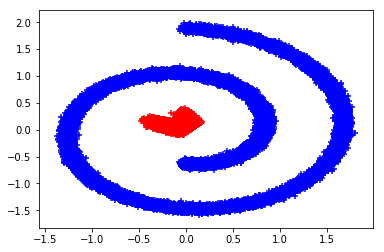

In [10]:
generate_image(train)

Epoch: 0/100, Step: 0, D Loss: 1.3969279527664185, G Loss: 0.7312378883361816


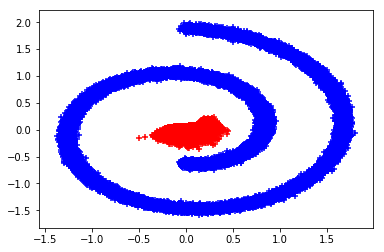

Epoch: 0/100, Step: 500, D Loss: 1.443726658821106, G Loss: 0.7953169941902161


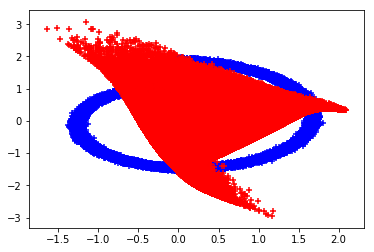

Epoch: 1/100, Step: 1000, D Loss: 1.3510982990264893, G Loss: 0.7053056359291077


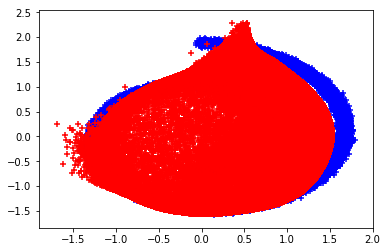

Epoch: 1/100, Step: 1500, D Loss: 1.3881065845489502, G Loss: 0.7242355942726135


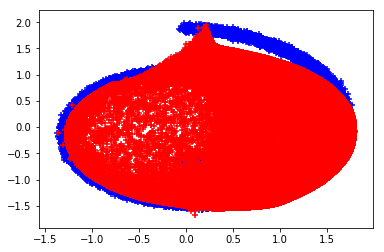

Epoch: 2/100, Step: 2000, D Loss: 1.3709511756896973, G Loss: 0.6846751570701599


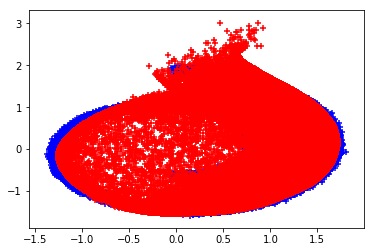

Epoch: 2/100, Step: 2500, D Loss: 1.3711187839508057, G Loss: 0.6627695560455322


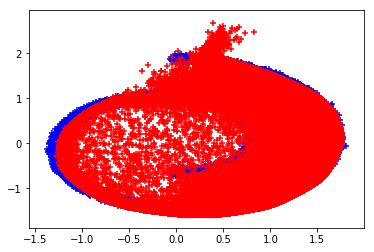

Epoch: 3/100, Step: 3000, D Loss: 1.3747482299804688, G Loss: 0.7107111811637878


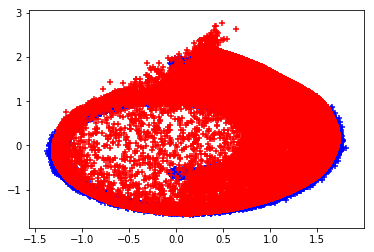

Epoch: 3/100, Step: 3500, D Loss: 1.3706599473953247, G Loss: 0.7250494360923767


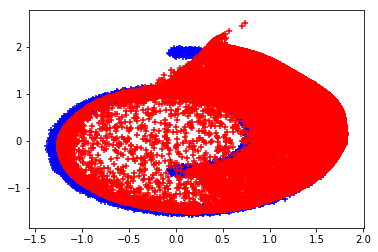

Epoch: 4/100, Step: 4000, D Loss: 1.38056480884552, G Loss: 0.7175363302230835


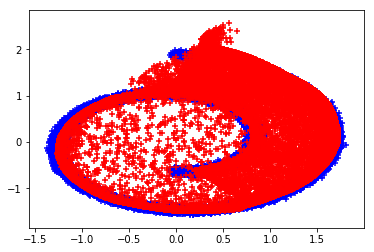

Epoch: 4/100, Step: 4500, D Loss: 1.3771820068359375, G Loss: 0.6952764987945557


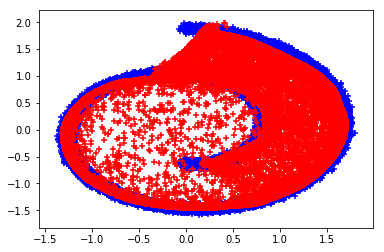

Epoch: 5/100, Step: 5000, D Loss: 1.3663301467895508, G Loss: 0.730376124382019


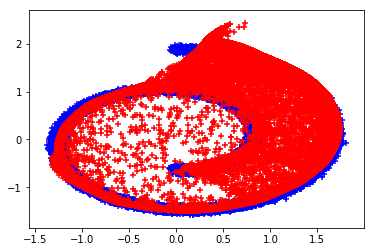

Epoch: 5/100, Step: 5500, D Loss: 1.3826806545257568, G Loss: 0.6747743487358093


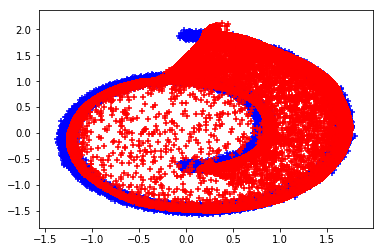

Epoch: 6/100, Step: 6000, D Loss: 1.3721179962158203, G Loss: 0.7030019760131836


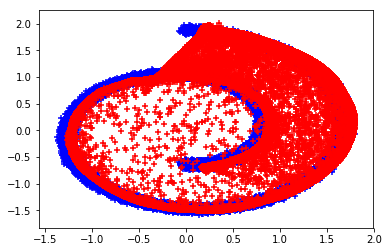

Epoch: 6/100, Step: 6500, D Loss: 1.3690853118896484, G Loss: 0.6598353385925293


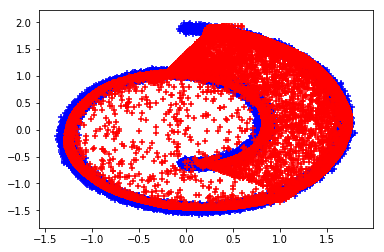

Epoch: 7/100, Step: 7000, D Loss: 1.3827483654022217, G Loss: 0.6967843770980835


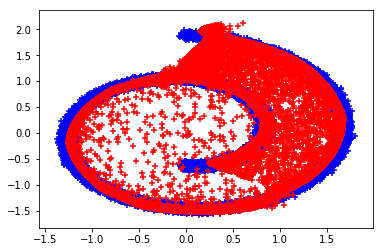

Epoch: 7/100, Step: 7500, D Loss: 1.3954944610595703, G Loss: 0.6753048896789551


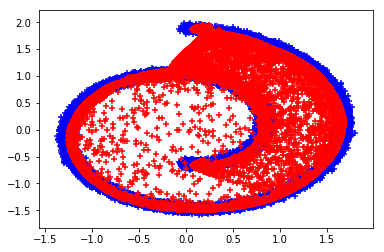

Epoch: 8/100, Step: 8000, D Loss: 1.3794527053833008, G Loss: 0.6659444570541382


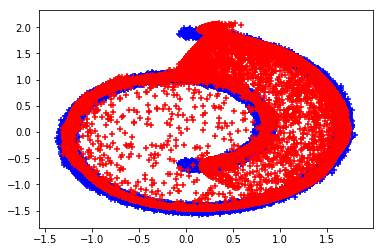

Epoch: 8/100, Step: 8500, D Loss: 1.3921666145324707, G Loss: 0.6752469539642334


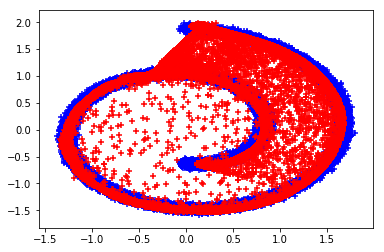

Epoch: 9/100, Step: 9000, D Loss: 1.388458251953125, G Loss: 0.6822490096092224


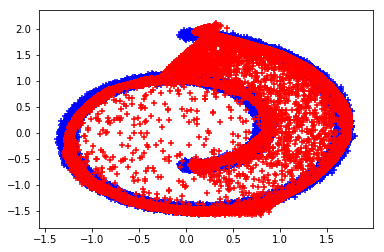

Epoch: 9/100, Step: 9500, D Loss: 1.3921284675598145, G Loss: 0.6935173273086548


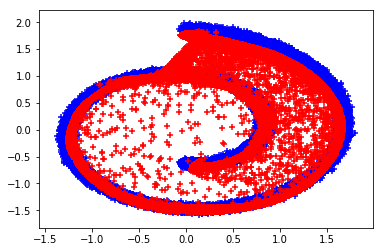

Epoch: 10/100, Step: 10000, D Loss: 1.3975207805633545, G Loss: 0.6950032711029053


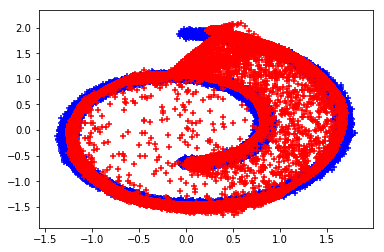

Epoch: 10/100, Step: 10500, D Loss: 1.3874746561050415, G Loss: 0.6845475435256958


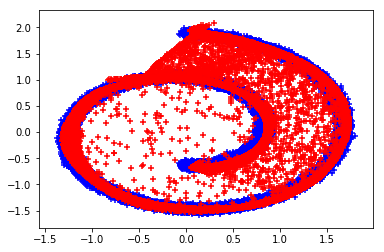

Epoch: 11/100, Step: 11000, D Loss: 1.3864370584487915, G Loss: 0.6891916990280151


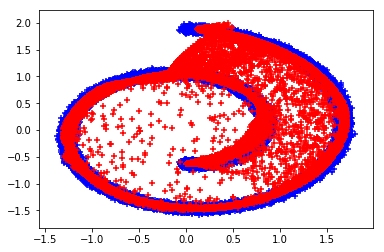

Epoch: 11/100, Step: 11500, D Loss: 1.384709119796753, G Loss: 0.6787612438201904


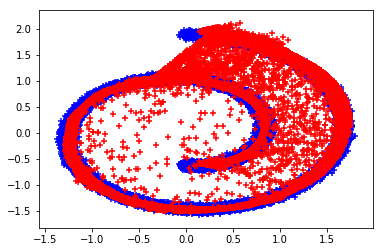

Epoch: 12/100, Step: 12000, D Loss: 1.3888405561447144, G Loss: 0.6884748935699463


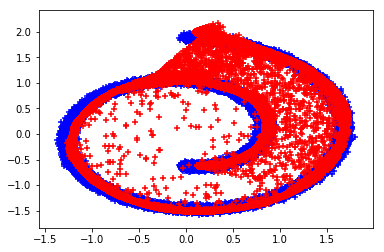

Epoch: 12/100, Step: 12500, D Loss: 1.378740906715393, G Loss: 0.6690529584884644


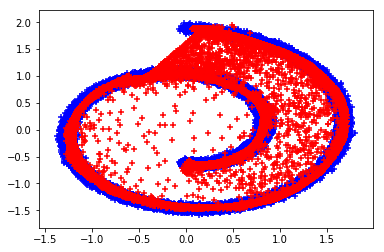

Epoch: 13/100, Step: 13000, D Loss: 1.3803343772888184, G Loss: 0.6909236907958984


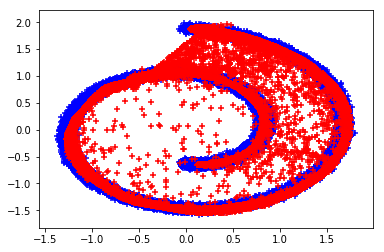

Epoch: 13/100, Step: 13500, D Loss: 1.3858052492141724, G Loss: 0.683814287185669


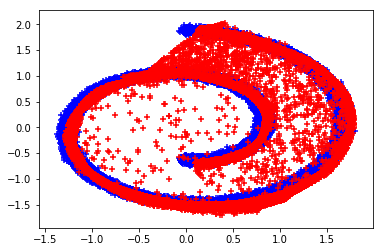

Epoch: 14/100, Step: 14000, D Loss: 1.3853094577789307, G Loss: 0.6827181577682495


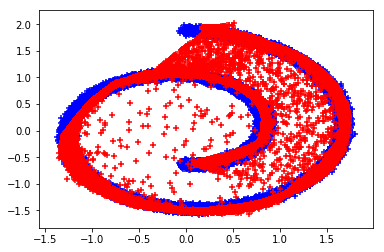

Epoch: 14/100, Step: 14500, D Loss: 1.380584478378296, G Loss: 0.7024779319763184


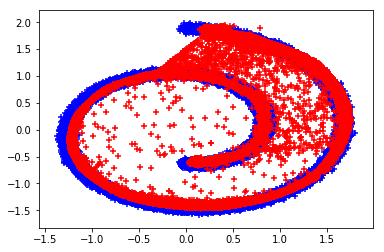

Epoch: 15/100, Step: 15000, D Loss: 1.3911584615707397, G Loss: 0.6823300719261169


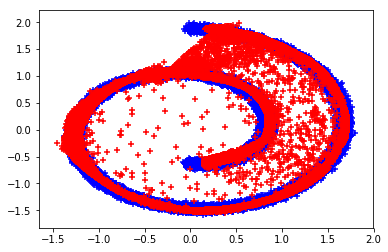

Epoch: 15/100, Step: 15500, D Loss: 1.382359266281128, G Loss: 0.6957255601882935


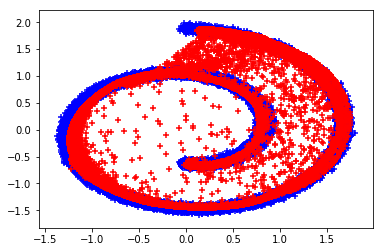

Epoch: 16/100, Step: 16000, D Loss: 1.3839008808135986, G Loss: 0.6896083354949951


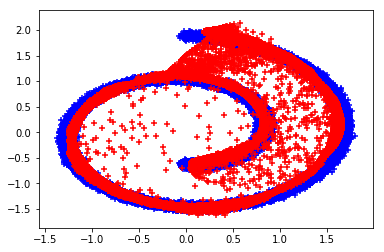

Epoch: 16/100, Step: 16500, D Loss: 1.3892755508422852, G Loss: 0.687853217124939


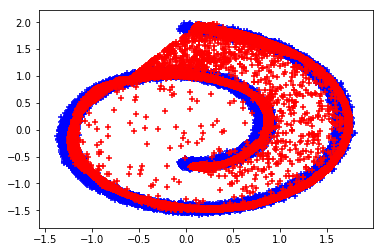

Epoch: 17/100, Step: 17000, D Loss: 1.3858094215393066, G Loss: 0.6937135457992554


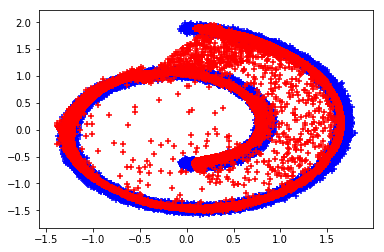

Epoch: 17/100, Step: 17500, D Loss: 1.3983445167541504, G Loss: 0.7013940811157227


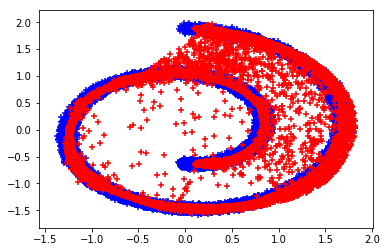

Epoch: 18/100, Step: 18000, D Loss: 1.3893266916275024, G Loss: 0.6723107099533081


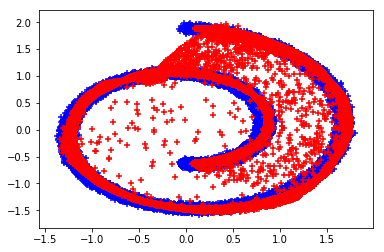

Epoch: 18/100, Step: 18500, D Loss: 1.3846310377120972, G Loss: 0.6990959644317627


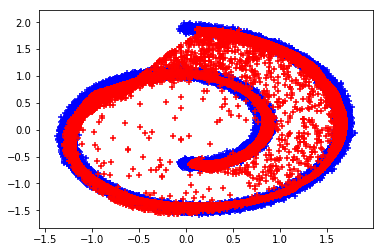

Epoch: 19/100, Step: 19000, D Loss: 1.38528573513031, G Loss: 0.6949061155319214


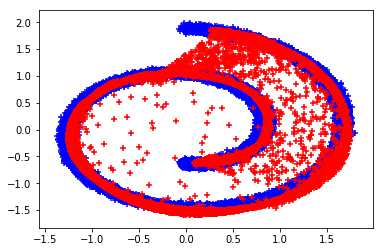

Epoch: 19/100, Step: 19500, D Loss: 1.3863484859466553, G Loss: 0.6871050000190735


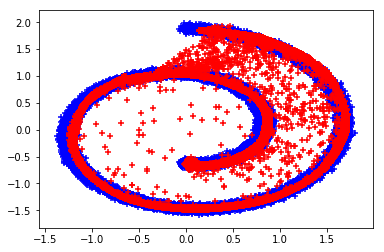

Epoch: 20/100, Step: 20000, D Loss: 1.3832085132598877, G Loss: 0.7125751972198486


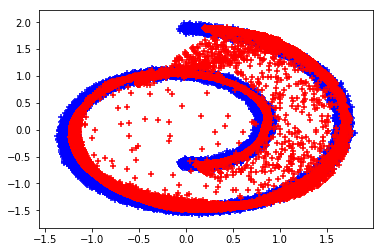

Epoch: 20/100, Step: 20500, D Loss: 1.3842380046844482, G Loss: 0.6932868957519531


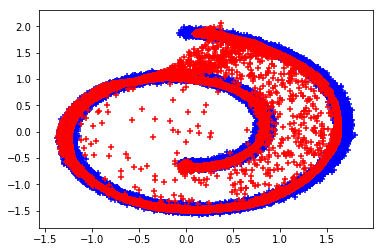

Epoch: 21/100, Step: 21000, D Loss: 1.3855997323989868, G Loss: 0.7019898891448975


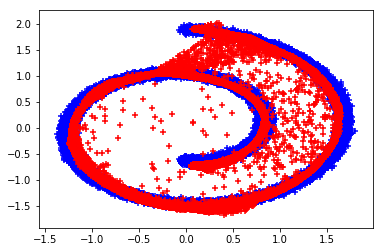

Epoch: 21/100, Step: 21500, D Loss: 1.3846662044525146, G Loss: 0.6909492015838623


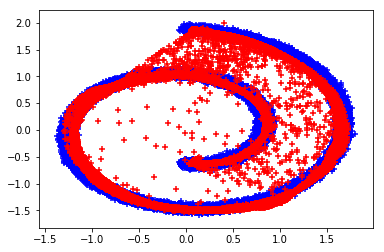

Epoch: 22/100, Step: 22000, D Loss: 1.3843046426773071, G Loss: 0.6921154260635376


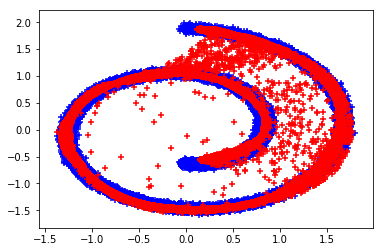

Epoch: 22/100, Step: 22500, D Loss: 1.3763720989227295, G Loss: 0.7009619474411011


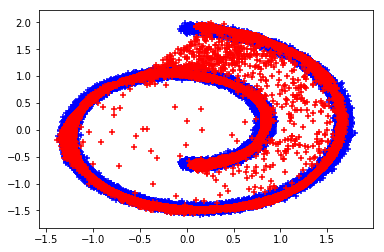

Epoch: 23/100, Step: 23000, D Loss: 1.381443738937378, G Loss: 0.6978545188903809


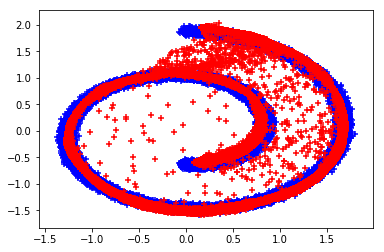

Epoch: 23/100, Step: 23500, D Loss: 1.382489800453186, G Loss: 0.7052018642425537


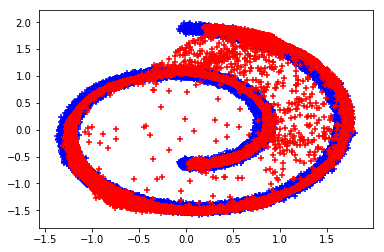

Epoch: 24/100, Step: 24000, D Loss: 1.3874881267547607, G Loss: 0.6908851265907288


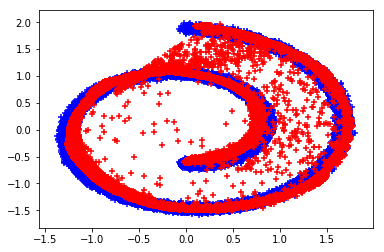

Epoch: 24/100, Step: 24500, D Loss: 1.3831168413162231, G Loss: 0.6995599865913391


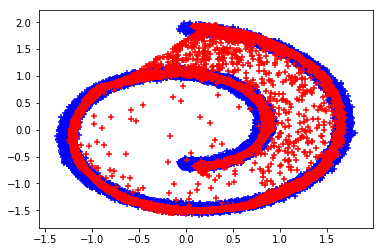

Epoch: 25/100, Step: 25000, D Loss: 1.3845534324645996, G Loss: 0.7012346982955933


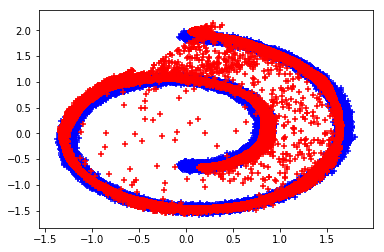

Epoch: 25/100, Step: 25500, D Loss: 1.38460111618042, G Loss: 0.6905637979507446


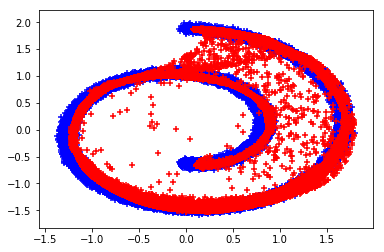

Epoch: 26/100, Step: 26000, D Loss: 1.380425214767456, G Loss: 0.7050034999847412


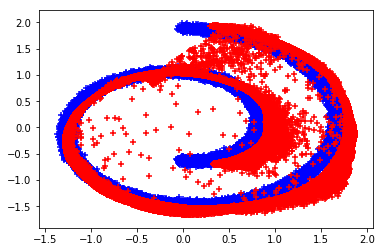

Epoch: 26/100, Step: 26500, D Loss: 1.3783153295516968, G Loss: 0.6946209073066711


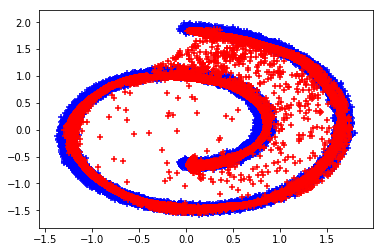

Epoch: 27/100, Step: 27000, D Loss: 1.384509801864624, G Loss: 0.687911868095398


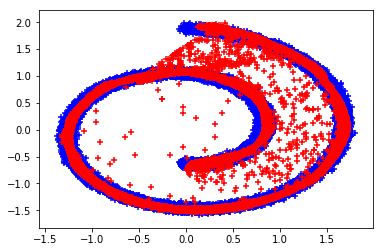

Epoch: 27/100, Step: 27500, D Loss: 1.3891477584838867, G Loss: 0.7005721926689148


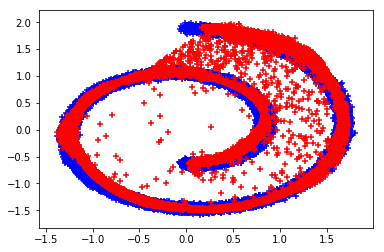

Epoch: 28/100, Step: 28000, D Loss: 1.3852487802505493, G Loss: 0.696700930595398


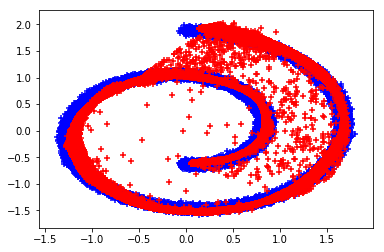

Epoch: 28/100, Step: 28500, D Loss: 1.3920986652374268, G Loss: 0.6936261653900146


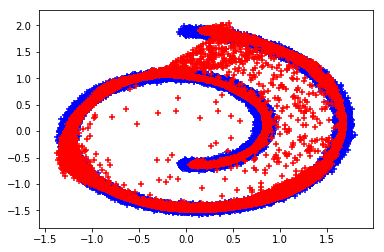

Epoch: 29/100, Step: 29000, D Loss: 1.3872671127319336, G Loss: 0.6962355375289917


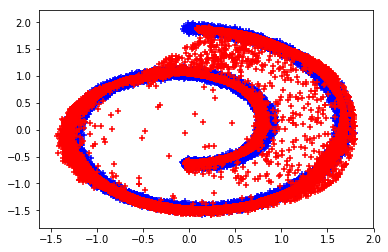

Epoch: 29/100, Step: 29500, D Loss: 1.3840978145599365, G Loss: 0.699360191822052


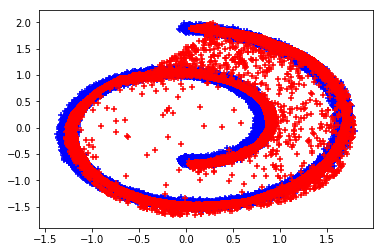

Epoch: 30/100, Step: 30000, D Loss: 1.390411138534546, G Loss: 0.6912894248962402


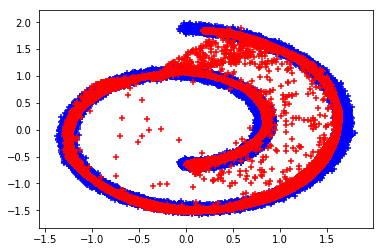

Epoch: 30/100, Step: 30500, D Loss: 1.3851189613342285, G Loss: 0.6917231678962708


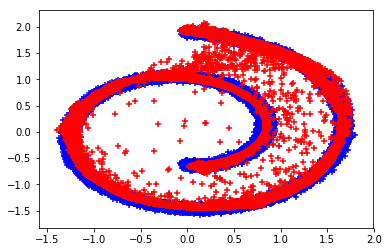

Epoch: 31/100, Step: 31000, D Loss: 1.3871098756790161, G Loss: 0.6890580654144287


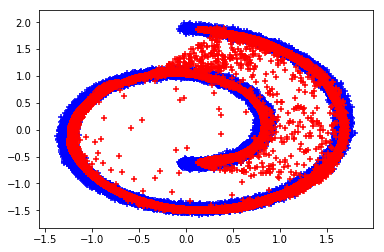

Epoch: 31/100, Step: 31500, D Loss: 1.3836920261383057, G Loss: 0.6949891448020935


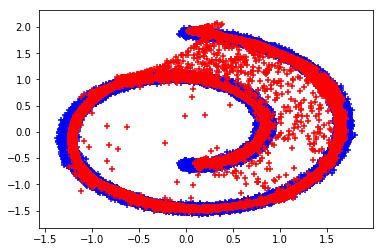

Epoch: 32/100, Step: 32000, D Loss: 1.386142611503601, G Loss: 0.6918861269950867


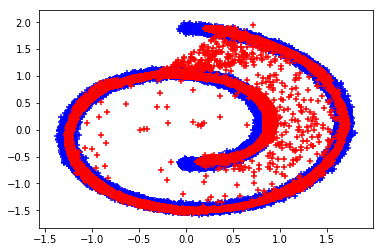

Epoch: 32/100, Step: 32500, D Loss: 1.3850575685501099, G Loss: 0.7007031440734863


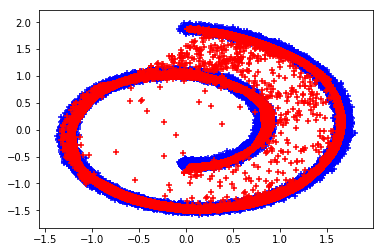

Epoch: 33/100, Step: 33000, D Loss: 1.3867160081863403, G Loss: 0.7006875276565552


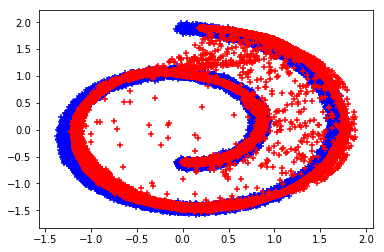

Epoch: 33/100, Step: 33500, D Loss: 1.3876451253890991, G Loss: 0.6934458017349243


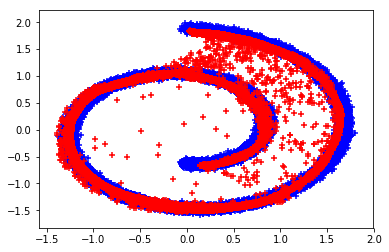

Epoch: 34/100, Step: 34000, D Loss: 1.3838412761688232, G Loss: 0.6942044496536255


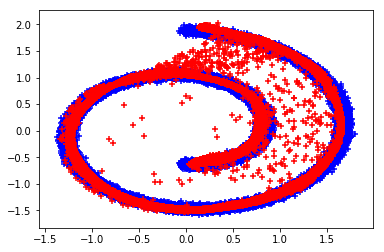

Epoch: 34/100, Step: 34500, D Loss: 1.388160228729248, G Loss: 0.7005021572113037


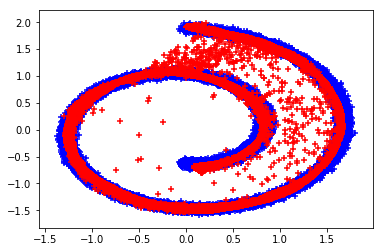

Epoch: 35/100, Step: 35000, D Loss: 1.3872886896133423, G Loss: 0.6936435699462891


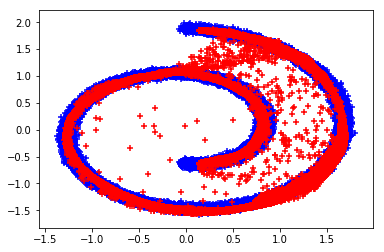

Epoch: 35/100, Step: 35500, D Loss: 1.3860498666763306, G Loss: 0.6903590559959412


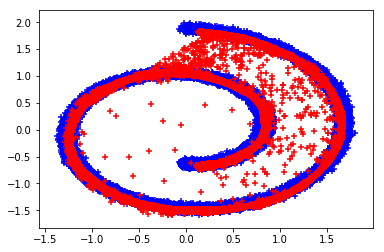

Epoch: 36/100, Step: 36000, D Loss: 1.3896703720092773, G Loss: 0.6946735978126526


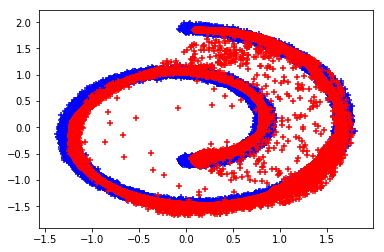

Epoch: 36/100, Step: 36500, D Loss: 1.3812170028686523, G Loss: 0.6905019879341125


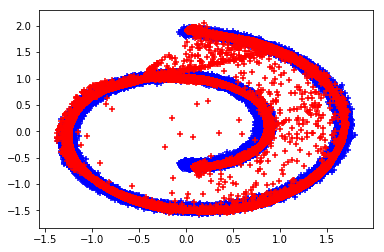

Epoch: 37/100, Step: 37000, D Loss: 1.3838615417480469, G Loss: 0.7198410034179688


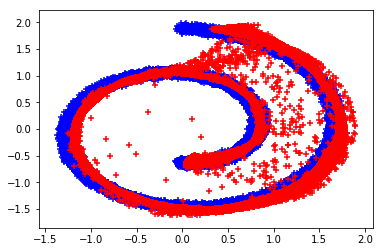

Epoch: 37/100, Step: 37500, D Loss: 1.384605050086975, G Loss: 0.695957362651825


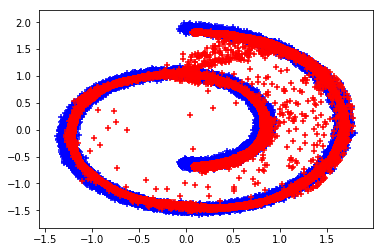

Epoch: 38/100, Step: 38000, D Loss: 1.3862537145614624, G Loss: 0.6969665884971619


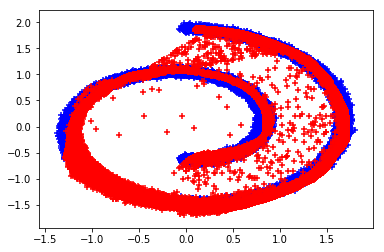

Epoch: 38/100, Step: 38500, D Loss: 1.3873004913330078, G Loss: 0.7066867351531982


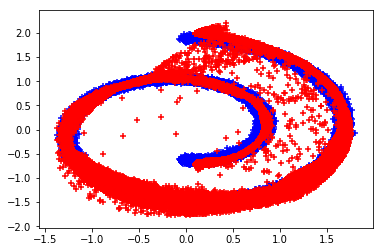

Epoch: 39/100, Step: 39000, D Loss: 1.3839702606201172, G Loss: 0.6986182928085327


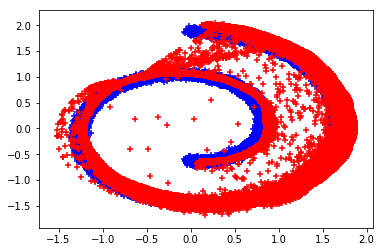

Epoch: 39/100, Step: 39500, D Loss: 1.385641098022461, G Loss: 0.6977291107177734


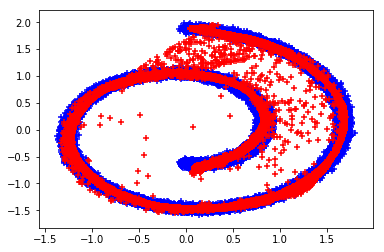

Epoch: 40/100, Step: 40000, D Loss: 1.384730339050293, G Loss: 0.6969970464706421


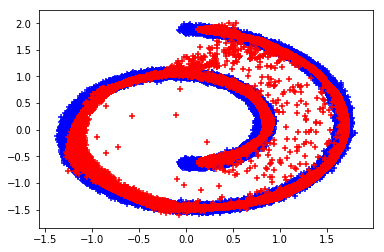

Epoch: 40/100, Step: 40500, D Loss: 1.3901488780975342, G Loss: 0.6915919780731201


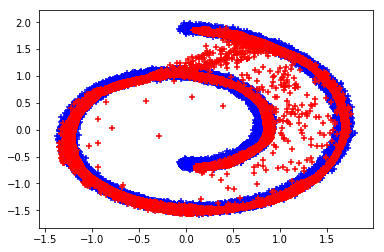

Epoch: 41/100, Step: 41000, D Loss: 1.3883029222488403, G Loss: 0.6900089979171753


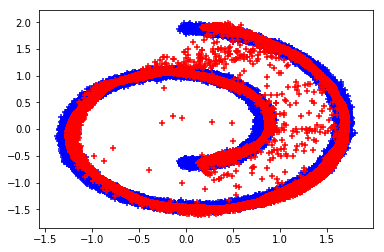

Epoch: 41/100, Step: 41500, D Loss: 1.3838413953781128, G Loss: 0.6969396471977234


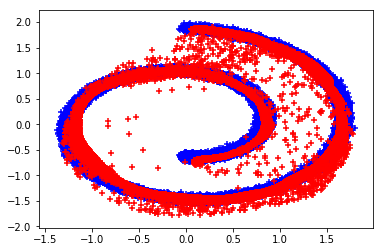

Epoch: 42/100, Step: 42000, D Loss: 1.384932518005371, G Loss: 0.6964433789253235


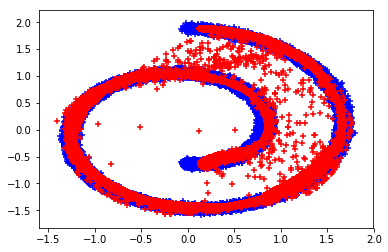

Epoch: 42/100, Step: 42500, D Loss: 1.395784854888916, G Loss: 0.698174238204956


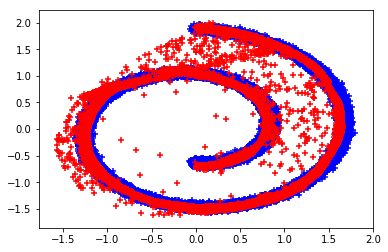

Epoch: 43/100, Step: 43000, D Loss: 1.3891041278839111, G Loss: 0.6943876147270203


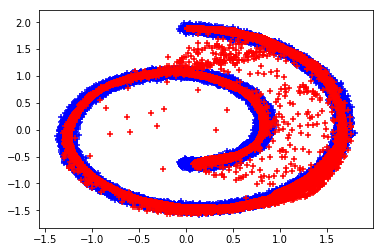

Epoch: 43/100, Step: 43500, D Loss: 1.3925013542175293, G Loss: 0.6913303136825562


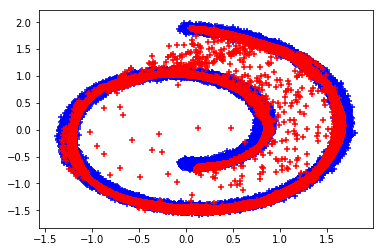

Epoch: 44/100, Step: 44000, D Loss: 1.3856388330459595, G Loss: 0.6905767917633057


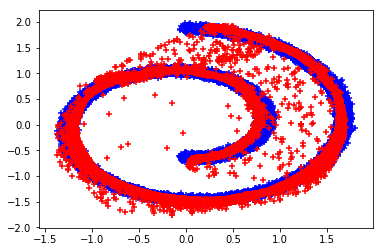

Epoch: 44/100, Step: 44500, D Loss: 1.3880671262741089, G Loss: 0.6929714679718018


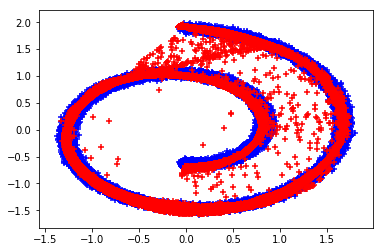

Epoch: 45/100, Step: 45000, D Loss: 1.3845828771591187, G Loss: 0.6935323476791382


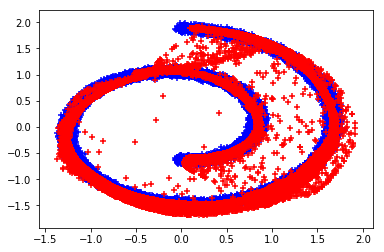

Epoch: 45/100, Step: 45500, D Loss: 1.3859045505523682, G Loss: 0.6943963766098022


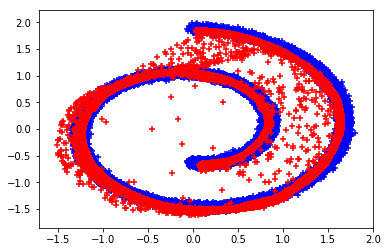

Epoch: 46/100, Step: 46000, D Loss: 1.3860974311828613, G Loss: 0.6954245567321777


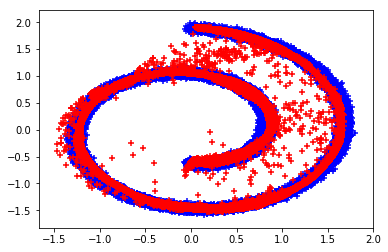

Epoch: 46/100, Step: 46500, D Loss: 1.378902554512024, G Loss: 0.7013009786605835


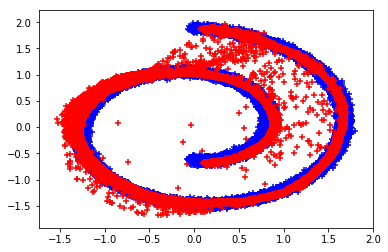

Epoch: 47/100, Step: 47000, D Loss: 1.3873181343078613, G Loss: 0.692968487739563


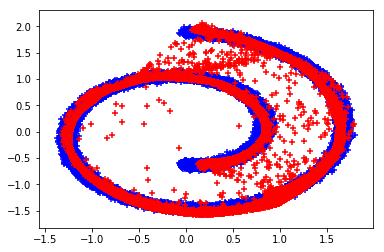

Epoch: 47/100, Step: 47500, D Loss: 1.3838599920272827, G Loss: 0.700034499168396


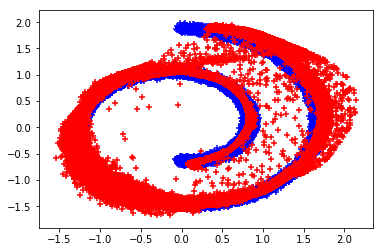

Epoch: 48/100, Step: 48000, D Loss: 1.3837802410125732, G Loss: 0.6952313780784607


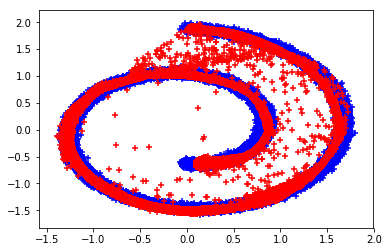

Epoch: 48/100, Step: 48500, D Loss: 1.3830249309539795, G Loss: 0.6992517113685608


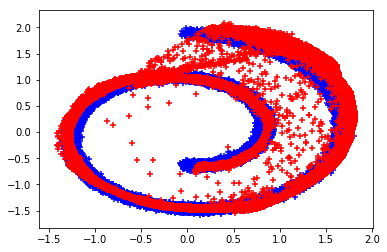

Epoch: 49/100, Step: 49000, D Loss: 1.381721019744873, G Loss: 0.6977149248123169


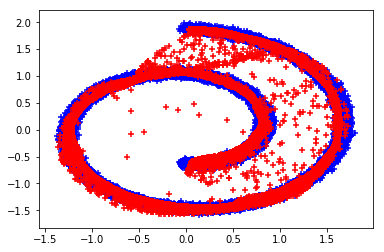

Epoch: 49/100, Step: 49500, D Loss: 1.3843510150909424, G Loss: 0.6900525093078613


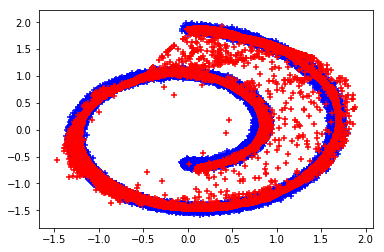

Epoch: 50/100, Step: 50000, D Loss: 1.3853709697723389, G Loss: 0.69670569896698


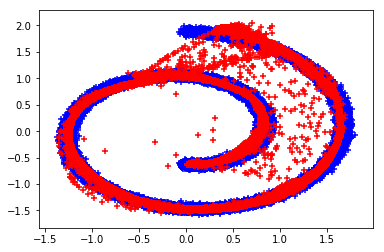

Epoch: 50/100, Step: 50500, D Loss: 1.3858723640441895, G Loss: 0.69441819190979


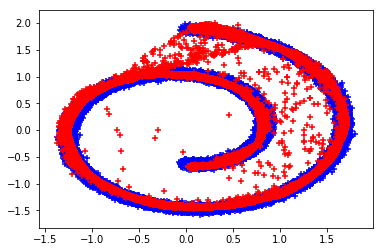

Epoch: 51/100, Step: 51000, D Loss: 1.3842682838439941, G Loss: 0.6932925581932068


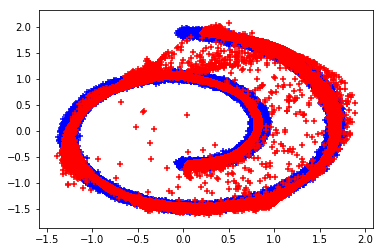

Epoch: 51/100, Step: 51500, D Loss: 1.3818132877349854, G Loss: 0.6961274147033691


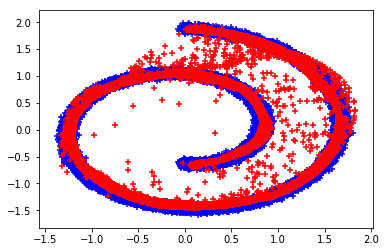

Epoch: 52/100, Step: 52000, D Loss: 1.3872488737106323, G Loss: 0.6918988227844238


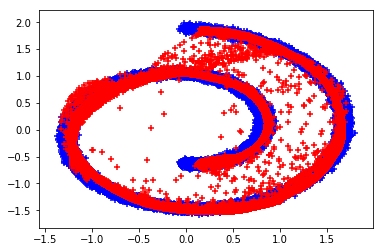

Epoch: 52/100, Step: 52500, D Loss: 1.3862035274505615, G Loss: 0.6931958198547363


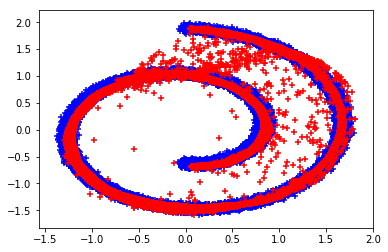

Epoch: 53/100, Step: 53000, D Loss: 1.3847413063049316, G Loss: 0.693867564201355


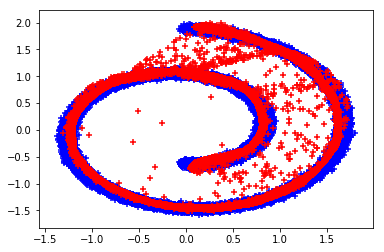

Epoch: 53/100, Step: 53500, D Loss: 1.3860790729522705, G Loss: 0.6951236724853516


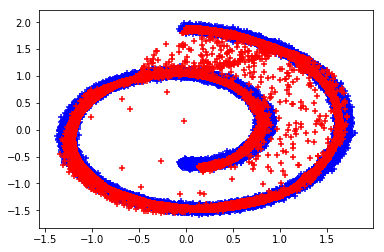

Epoch: 54/100, Step: 54000, D Loss: 1.3847862482070923, G Loss: 0.6988736391067505


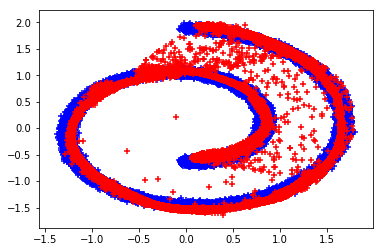

Epoch: 54/100, Step: 54500, D Loss: 1.3889696598052979, G Loss: 0.6907767653465271


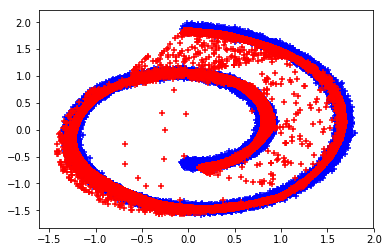

Epoch: 55/100, Step: 55000, D Loss: 1.3821271657943726, G Loss: 0.695786714553833


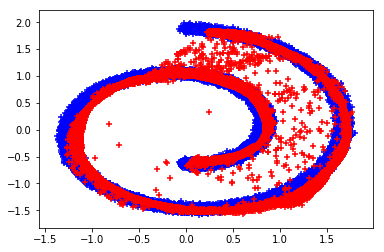

Epoch: 55/100, Step: 55500, D Loss: 1.386491298675537, G Loss: 0.6904150247573853


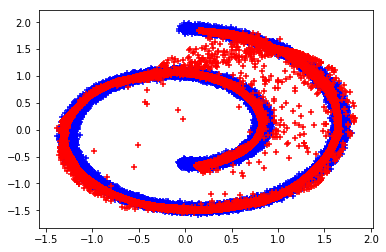

Epoch: 56/100, Step: 56000, D Loss: 1.38474440574646, G Loss: 0.6914550065994263


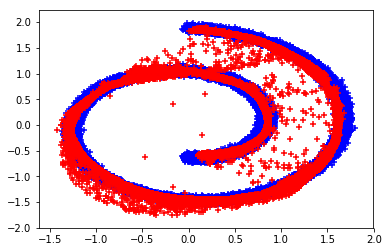

Epoch: 56/100, Step: 56500, D Loss: 1.3892788887023926, G Loss: 0.6914180517196655


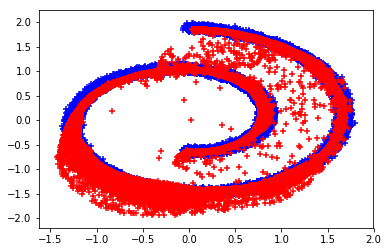

Epoch: 57/100, Step: 57000, D Loss: 1.3904584646224976, G Loss: 0.6925877332687378


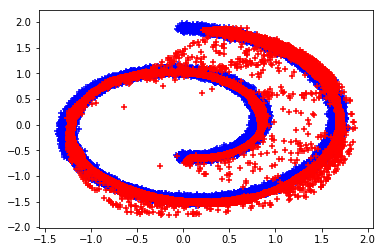

Epoch: 57/100, Step: 57500, D Loss: 1.383655309677124, G Loss: 0.6962863206863403


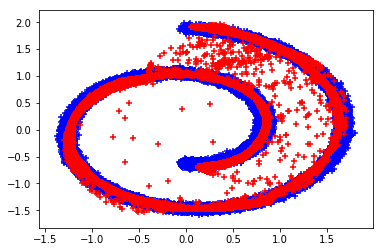

Epoch: 58/100, Step: 58000, D Loss: 1.3836932182312012, G Loss: 0.6911567449569702


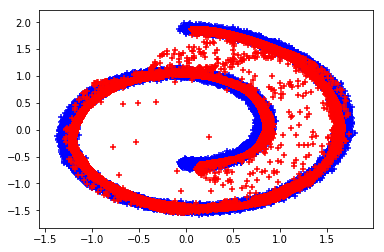

Epoch: 58/100, Step: 58500, D Loss: 1.3823938369750977, G Loss: 0.6947004795074463


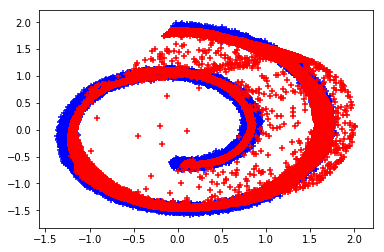

Epoch: 59/100, Step: 59000, D Loss: 1.387289047241211, G Loss: 0.6932486295700073


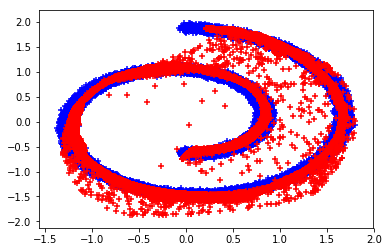

Epoch: 59/100, Step: 59500, D Loss: 1.389033317565918, G Loss: 0.6903123259544373


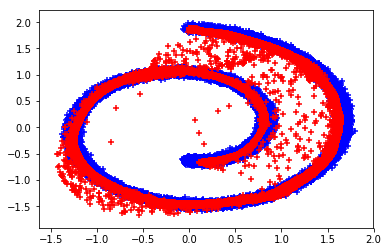

Epoch: 60/100, Step: 60000, D Loss: 1.3840000629425049, G Loss: 0.7221275568008423


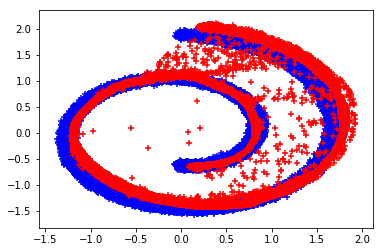

Epoch: 60/100, Step: 60500, D Loss: 1.3877880573272705, G Loss: 0.6909467577934265


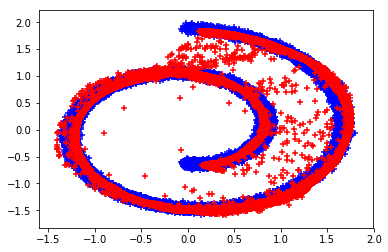

Epoch: 61/100, Step: 61000, D Loss: 1.3837168216705322, G Loss: 0.6943792700767517


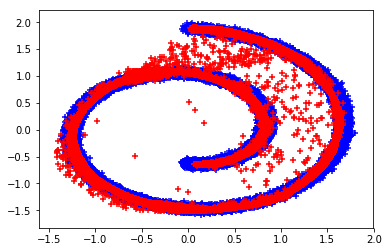

Epoch: 61/100, Step: 61500, D Loss: 1.38650643825531, G Loss: 0.6949887275695801


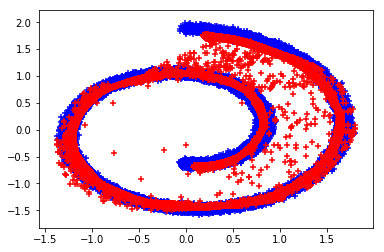

Epoch: 62/100, Step: 62000, D Loss: 1.3849304914474487, G Loss: 0.6869207620620728


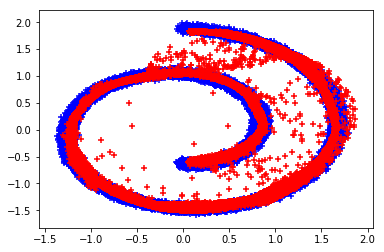

Epoch: 62/100, Step: 62500, D Loss: 1.385372281074524, G Loss: 0.6963051557540894


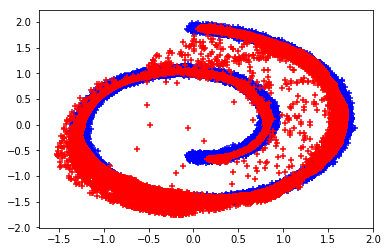

Epoch: 63/100, Step: 63000, D Loss: 1.386847734451294, G Loss: 0.6895724534988403


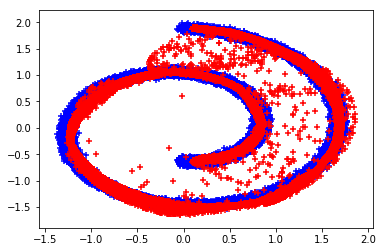

Epoch: 63/100, Step: 63500, D Loss: 1.388371467590332, G Loss: 0.6925181150436401


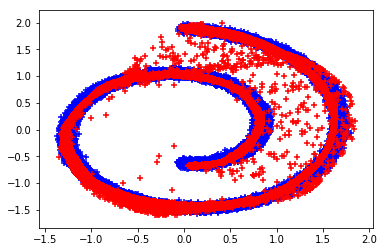

Epoch: 64/100, Step: 64000, D Loss: 1.3883161544799805, G Loss: 0.6943378448486328


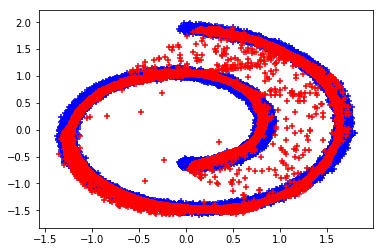

Epoch: 64/100, Step: 64500, D Loss: 1.387700080871582, G Loss: 0.6933317184448242


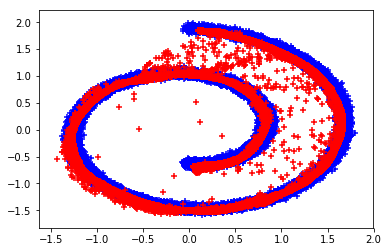

Epoch: 65/100, Step: 65000, D Loss: 1.3862496614456177, G Loss: 0.6935060620307922


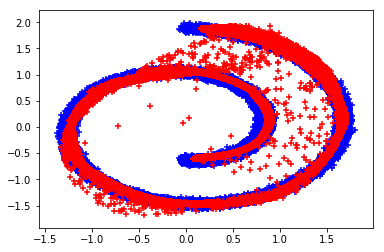

Epoch: 65/100, Step: 65500, D Loss: 1.384765386581421, G Loss: 0.6923784017562866


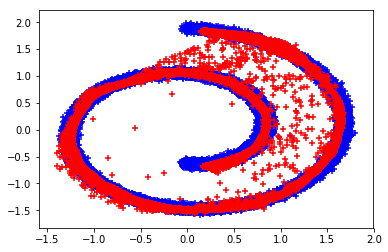

Epoch: 66/100, Step: 66000, D Loss: 1.3836719989776611, G Loss: 0.6906148195266724


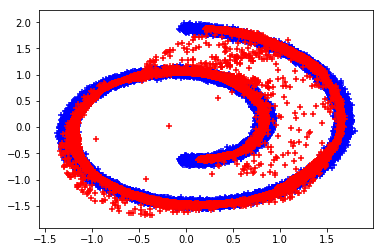

Epoch: 66/100, Step: 66500, D Loss: 1.3839795589447021, G Loss: 0.6920267343521118


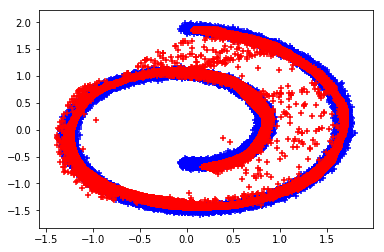

Epoch: 67/100, Step: 67000, D Loss: 1.3877437114715576, G Loss: 0.6891611814498901


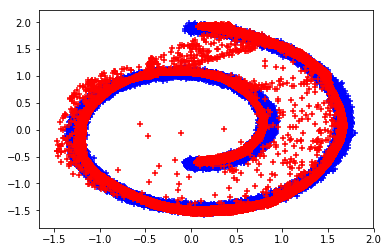

Epoch: 67/100, Step: 67500, D Loss: 1.381014347076416, G Loss: 0.6942111253738403


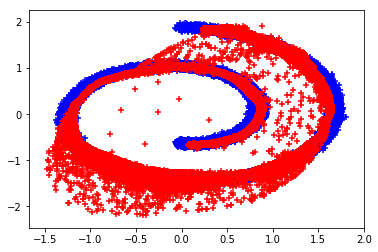

Epoch: 68/100, Step: 68000, D Loss: 1.383556842803955, G Loss: 0.6931073665618896


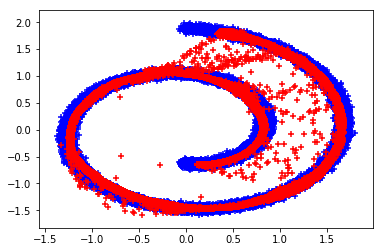

Epoch: 68/100, Step: 68500, D Loss: 1.3868632316589355, G Loss: 0.6930542588233948


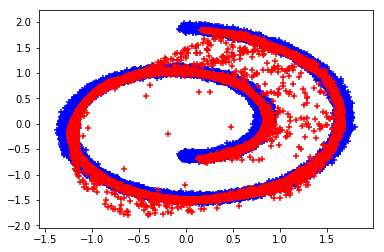

Epoch: 69/100, Step: 69000, D Loss: 1.3873605728149414, G Loss: 0.6958518028259277


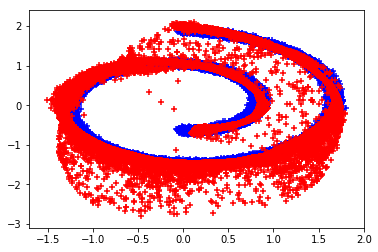

Epoch: 69/100, Step: 69500, D Loss: 1.3844866752624512, G Loss: 0.6902625560760498


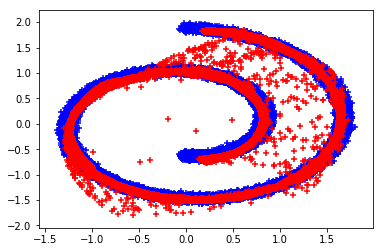

Epoch: 70/100, Step: 70000, D Loss: 1.3854974508285522, G Loss: 0.6939054727554321


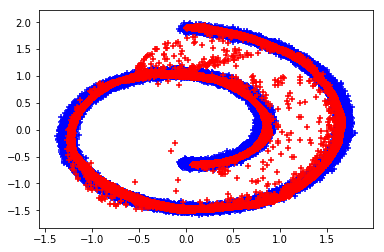

Epoch: 70/100, Step: 70500, D Loss: 1.385269284248352, G Loss: 0.6920675039291382


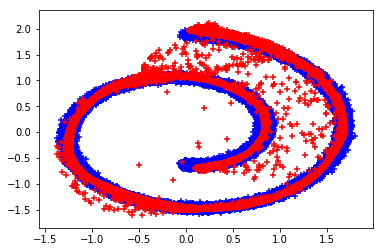

Epoch: 71/100, Step: 71000, D Loss: 1.387157917022705, G Loss: 0.6897099614143372


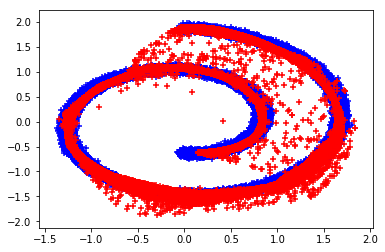

Epoch: 71/100, Step: 71500, D Loss: 1.388474702835083, G Loss: 0.6897567510604858


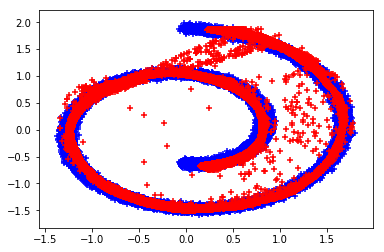

Epoch: 72/100, Step: 72000, D Loss: 1.3847979307174683, G Loss: 0.692888081073761


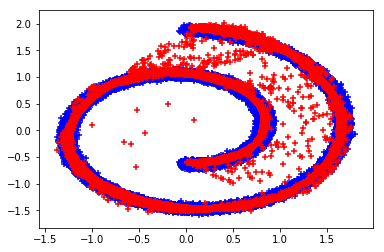

Epoch: 72/100, Step: 72500, D Loss: 1.385882019996643, G Loss: 0.6930139660835266


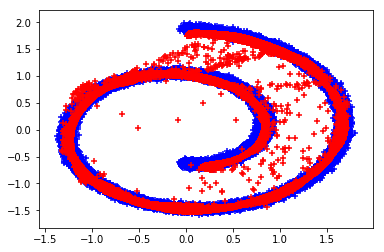

Epoch: 73/100, Step: 73000, D Loss: 1.38623046875, G Loss: 0.6932340860366821


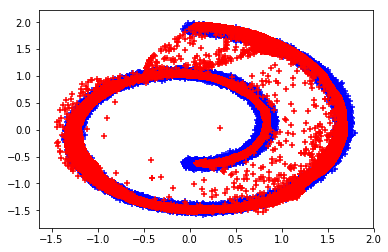

Epoch: 73/100, Step: 73500, D Loss: 1.3867278099060059, G Loss: 0.693083643913269


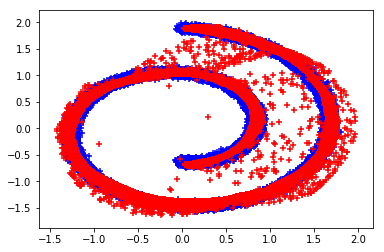

Epoch: 74/100, Step: 74000, D Loss: 1.3862388134002686, G Loss: 0.6911294460296631


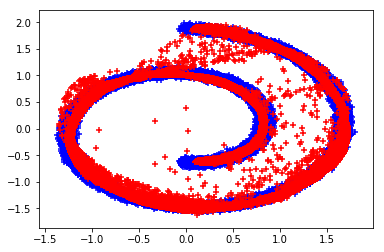

Epoch: 74/100, Step: 74500, D Loss: 1.383775234222412, G Loss: 0.6892867088317871


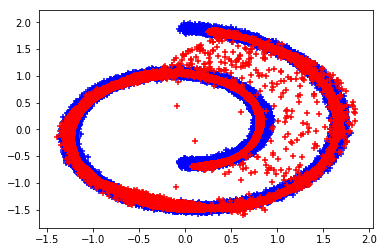

Epoch: 75/100, Step: 75000, D Loss: 1.3863481283187866, G Loss: 0.6931208372116089


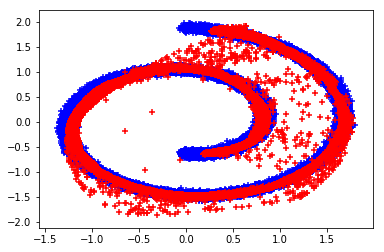

Epoch: 75/100, Step: 75500, D Loss: 1.386663794517517, G Loss: 0.691842257976532


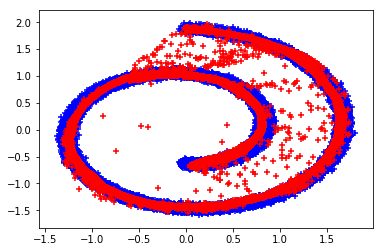

Epoch: 76/100, Step: 76000, D Loss: 1.3825355768203735, G Loss: 0.6893393993377686


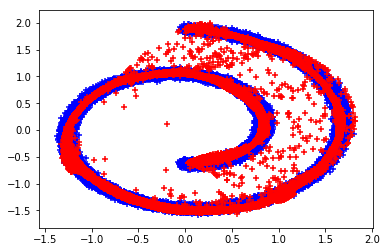

Epoch: 76/100, Step: 76500, D Loss: 1.3839190006256104, G Loss: 0.6915323734283447


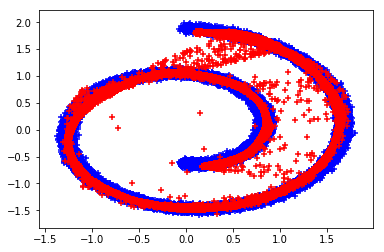

Epoch: 77/100, Step: 77000, D Loss: 1.3829643726348877, G Loss: 0.6978877782821655


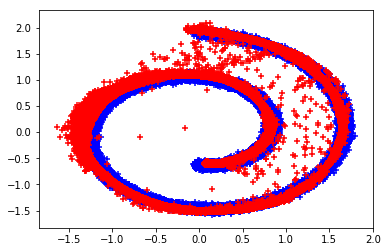

Epoch: 77/100, Step: 77500, D Loss: 1.3874796628952026, G Loss: 0.6935010552406311


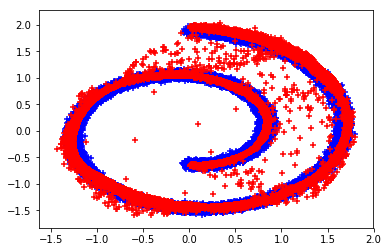

Epoch: 78/100, Step: 78000, D Loss: 1.3855433464050293, G Loss: 0.6871709823608398


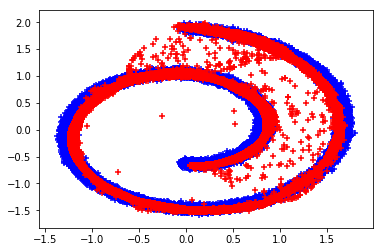

Epoch: 78/100, Step: 78500, D Loss: 1.386551856994629, G Loss: 0.6923243999481201


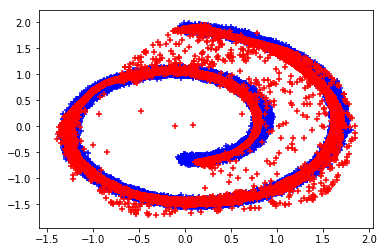

Epoch: 79/100, Step: 79000, D Loss: 1.3845559358596802, G Loss: 0.6916064620018005


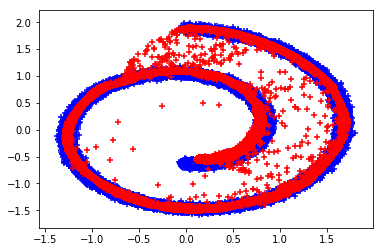

Epoch: 79/100, Step: 79500, D Loss: 1.3858318328857422, G Loss: 0.6949089169502258


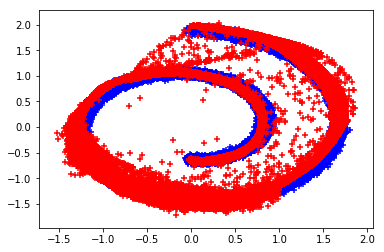

Epoch: 80/100, Step: 80000, D Loss: 1.3862929344177246, G Loss: 0.6924399733543396


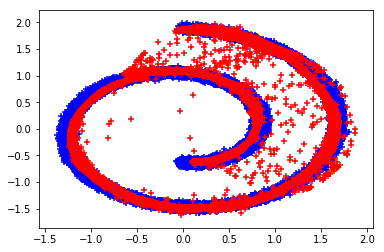

Epoch: 80/100, Step: 80500, D Loss: 1.3852543830871582, G Loss: 0.6940181255340576


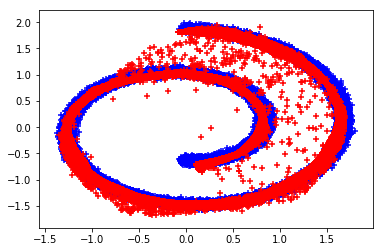

Epoch: 81/100, Step: 81000, D Loss: 1.3884392976760864, G Loss: 0.6881983280181885


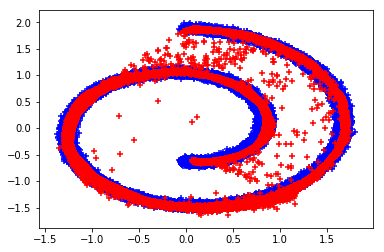

Epoch: 81/100, Step: 81500, D Loss: 1.3850889205932617, G Loss: 0.6921720504760742


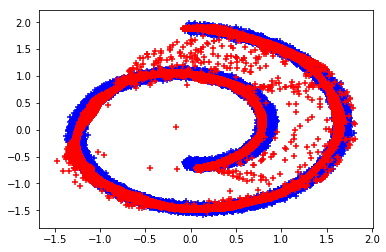

Epoch: 82/100, Step: 82000, D Loss: 1.3835244178771973, G Loss: 0.688933253288269


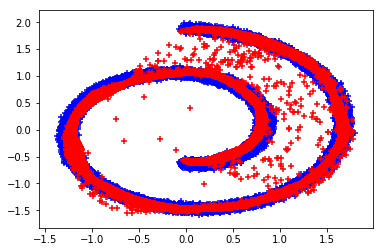

Epoch: 82/100, Step: 82500, D Loss: 1.3872565031051636, G Loss: 0.6917186379432678


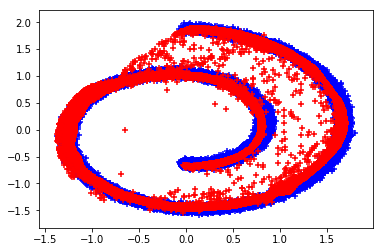

Epoch: 83/100, Step: 83000, D Loss: 1.3845648765563965, G Loss: 0.6897053718566895


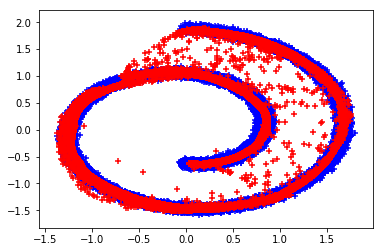

Epoch: 83/100, Step: 83500, D Loss: 1.386017084121704, G Loss: 0.6893231868743896


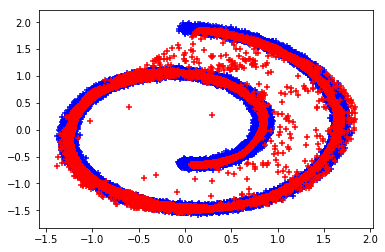

Epoch: 84/100, Step: 84000, D Loss: 1.3854552507400513, G Loss: 0.6905237436294556


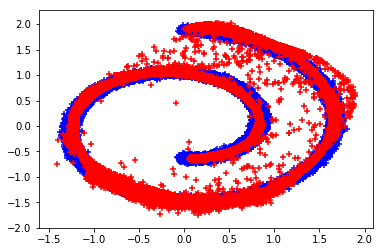

Epoch: 84/100, Step: 84500, D Loss: 1.386223316192627, G Loss: 0.690912663936615


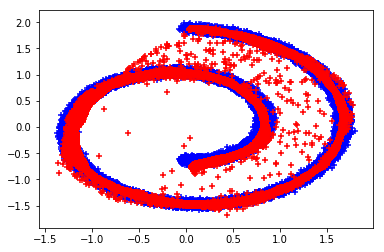

Epoch: 85/100, Step: 85000, D Loss: 1.388688087463379, G Loss: 0.6911088228225708


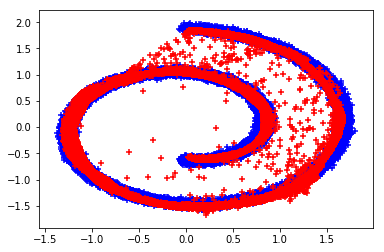

Epoch: 85/100, Step: 85500, D Loss: 1.3874434232711792, G Loss: 0.6926915645599365


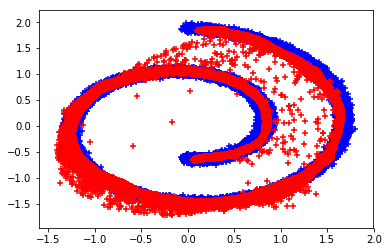

Epoch: 86/100, Step: 86000, D Loss: 1.3846005201339722, G Loss: 0.6898305416107178


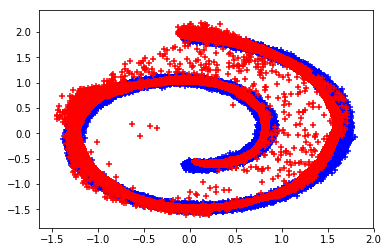

Epoch: 86/100, Step: 86500, D Loss: 1.3870980739593506, G Loss: 0.7269388437271118


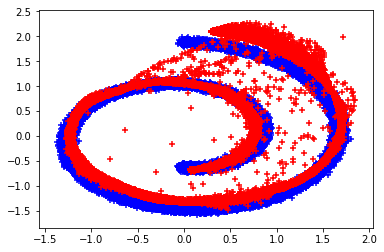

Epoch: 87/100, Step: 87000, D Loss: 1.3833175897598267, G Loss: 0.6915363073348999


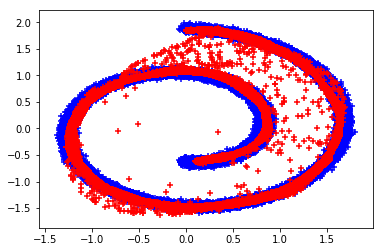

Epoch: 87/100, Step: 87500, D Loss: 1.386206865310669, G Loss: 0.6908566355705261


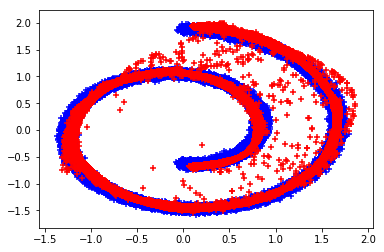

Epoch: 88/100, Step: 88000, D Loss: 1.3879705667495728, G Loss: 0.688765823841095


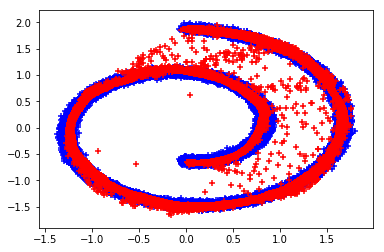

Epoch: 88/100, Step: 88500, D Loss: 1.38502836227417, G Loss: 0.6881890296936035


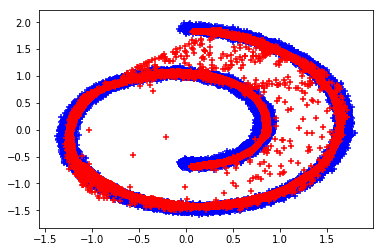

Epoch: 89/100, Step: 89000, D Loss: 1.3855215311050415, G Loss: 0.691636323928833


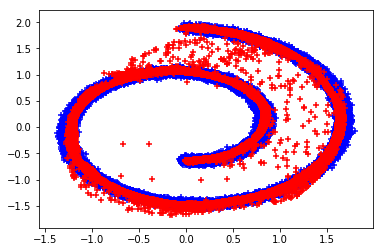

Epoch: 89/100, Step: 89500, D Loss: 1.3762948513031006, G Loss: 0.6974490880966187


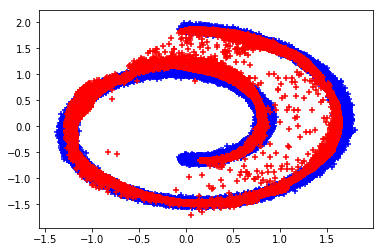

Epoch: 90/100, Step: 90000, D Loss: 1.3849527835845947, G Loss: 0.6923109889030457


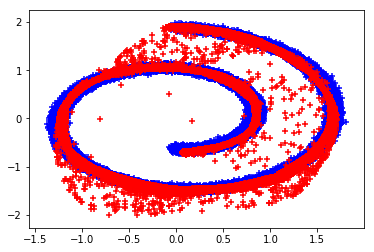

Epoch: 90/100, Step: 90500, D Loss: 1.3866961002349854, G Loss: 0.6885703802108765


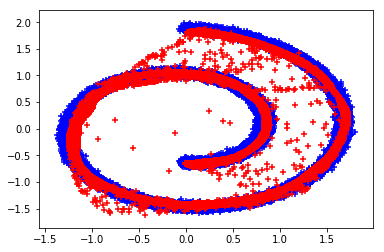

Epoch: 91/100, Step: 91000, D Loss: 1.3859002590179443, G Loss: 0.6924453973770142


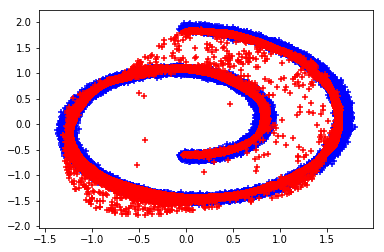

Epoch: 91/100, Step: 91500, D Loss: 1.387024164199829, G Loss: 0.6897953748703003


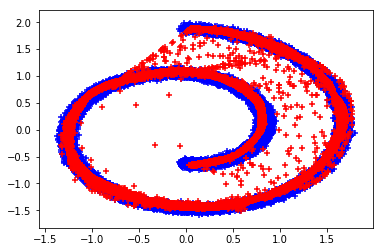

Epoch: 92/100, Step: 92000, D Loss: 1.3858987092971802, G Loss: 0.6905941963195801


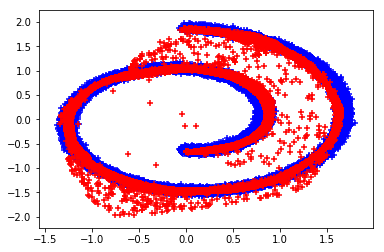

Epoch: 92/100, Step: 92500, D Loss: 1.3864977359771729, G Loss: 0.6945968270301819


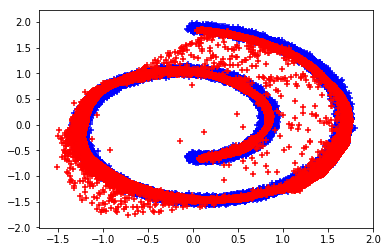

Epoch: 93/100, Step: 93000, D Loss: 1.3845316171646118, G Loss: 0.6877766847610474


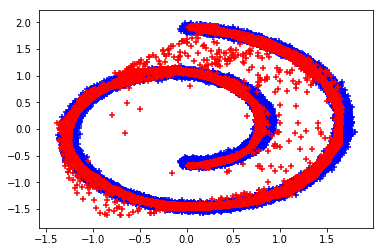

Epoch: 93/100, Step: 93500, D Loss: 1.386448621749878, G Loss: 0.6922392845153809


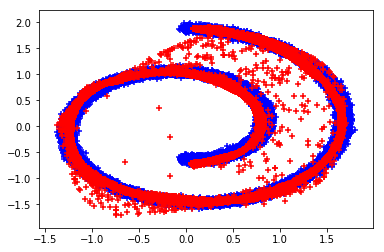

Epoch: 94/100, Step: 94000, D Loss: 1.381737470626831, G Loss: 0.6941432952880859


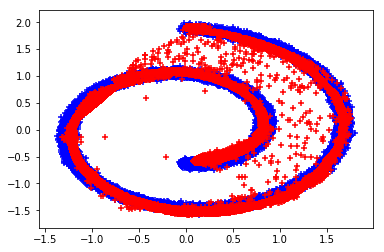

Epoch: 94/100, Step: 94500, D Loss: 1.3848717212677002, G Loss: 0.6910670399665833


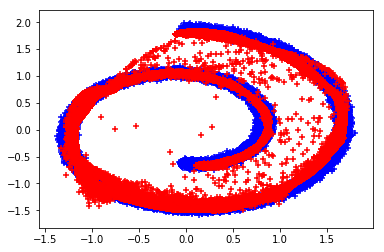

Epoch: 95/100, Step: 95000, D Loss: 1.3858740329742432, G Loss: 0.693144679069519


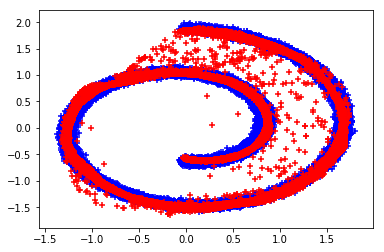

Epoch: 95/100, Step: 95500, D Loss: 1.3828330039978027, G Loss: 0.6891139149665833


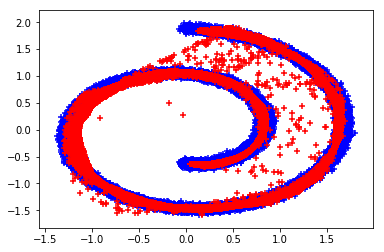

Epoch: 96/100, Step: 96000, D Loss: 1.3873704671859741, G Loss: 0.6887878179550171


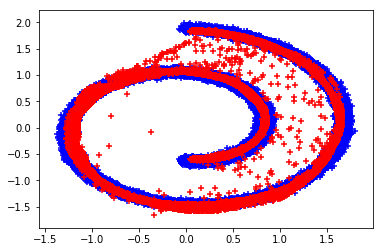

Epoch: 96/100, Step: 96500, D Loss: 1.3862788677215576, G Loss: 0.6894321441650391


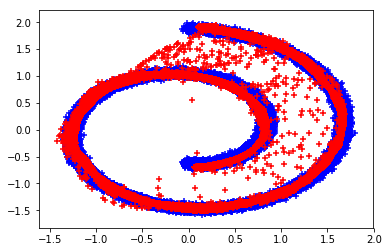

Epoch: 97/100, Step: 97000, D Loss: 1.383784294128418, G Loss: 0.6936674118041992


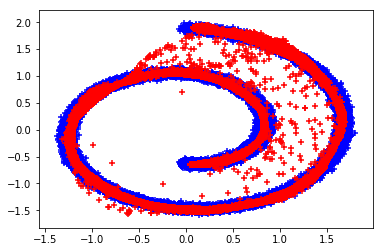

Epoch: 97/100, Step: 97500, D Loss: 1.384824275970459, G Loss: 0.6895652413368225


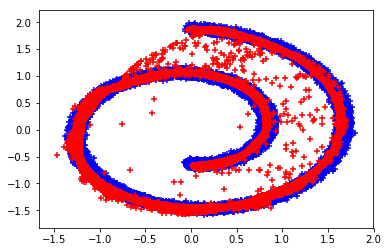

Epoch: 98/100, Step: 98000, D Loss: 1.3872063159942627, G Loss: 0.6894053220748901


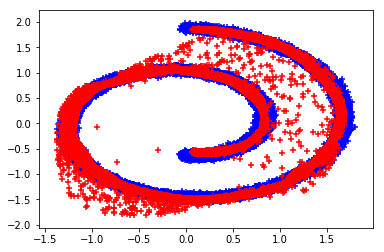

Epoch: 98/100, Step: 98500, D Loss: 1.3831826448440552, G Loss: 0.6892520785331726


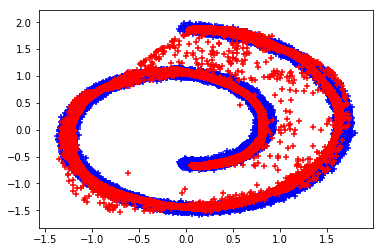

Epoch: 99/100, Step: 99000, D Loss: 1.388656735420227, G Loss: 0.690767228603363


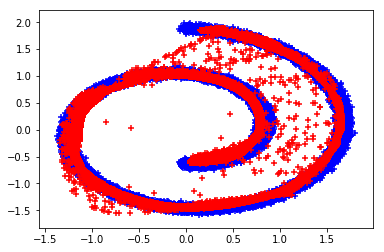

Epoch: 99/100, Step: 99500, D Loss: 1.3863321542739868, G Loss: 0.6884794235229492


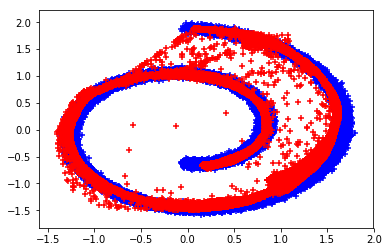

In [11]:
for epoch in range(max_epoch):
    for idx, x in enumerate(train):
        # Training Discriminator
        
        x = torch.Tensor(x)

        if DEVICE == torch.device("cuda"):
            x = x.cuda()
        
        x = torch.autograd.Variable(x)  
        x_outputs = D(x)      

        D_x_loss = criterion(x_outputs, D_labels)


        z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
            generate_image(train)
        step += 1